In [122]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from vad import EnergyVAD
import pywt
from scipy.stats import kurtosis
from scipy.stats import skew
import numpy as np
from scipy.fft import fft, ifft

In [123]:
# Load sample audio for testing
file_path = 'audio_batch_1/common_voice_en_20047755.mp3'
audio, sr = librosa.load(file_path, sr=None)

In [124]:
# voice activity mask - to keep only voiced parts (step 1 preprocessing) ---lw el sot waty awy by3tbro unvoiced?

# Reshape to (1, num_samples) for compatibility with EnergyVAD
def apply_vad(audio, sr):
    audio_2d = np.expand_dims(audio, axis=0)

    # Initialize VAD
    vad = EnergyVAD(
        sample_rate=16000,
        frame_length=25,
        frame_shift=20,
        energy_threshold=0.05,
        pre_emphasis=0.95,
    )

    # Get voice activity (1D boolean array per frame)
    voice_activity = vad(audio_2d)

    # Apply VAD to get speech-only waveform
    speech_signal = vad.apply_vad(audio_2d).flatten()

    # Frame-based time axis for VAD output
    frame_shift_samples = int(sr * (vad.frame_shift / 1000.0))
    frame_times = np.arange(len(voice_activity)) * frame_shift_samples / sr

    # Plotting
    # plt.figure(figsize=(14, 8))

    # # Original waveform
    # plt.subplot(3, 1, 1)
    # plt.plot(np.arange(len(audio)) / sr, audio, label='Original Audio', color='blue')
    # plt.title("Original Audio Waveform")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Amplitude")

    # # VAD output (voice activity mask)
    # plt.subplot(3, 1, 2)
    # plt.step(frame_times, voice_activity, label="Voice Activity (1=Speech, 0=Silence)", color='red')
    # plt.ylim(-0.1, 1.1)
    # plt.title("Voice Activity Detection")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Speech/Non-Speech")

    # # Speech-only waveform after VAD
    # plt.subplot(3, 1, 3)
    # plt.plot(np.arange(len(speech_signal)) / sr, speech_signal, label='Speech After VAD', color='green')
    # plt.title("Speech Signal After VAD")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Amplitude")

    # plt.tight_layout()
    # plt.show()
    return speech_signal


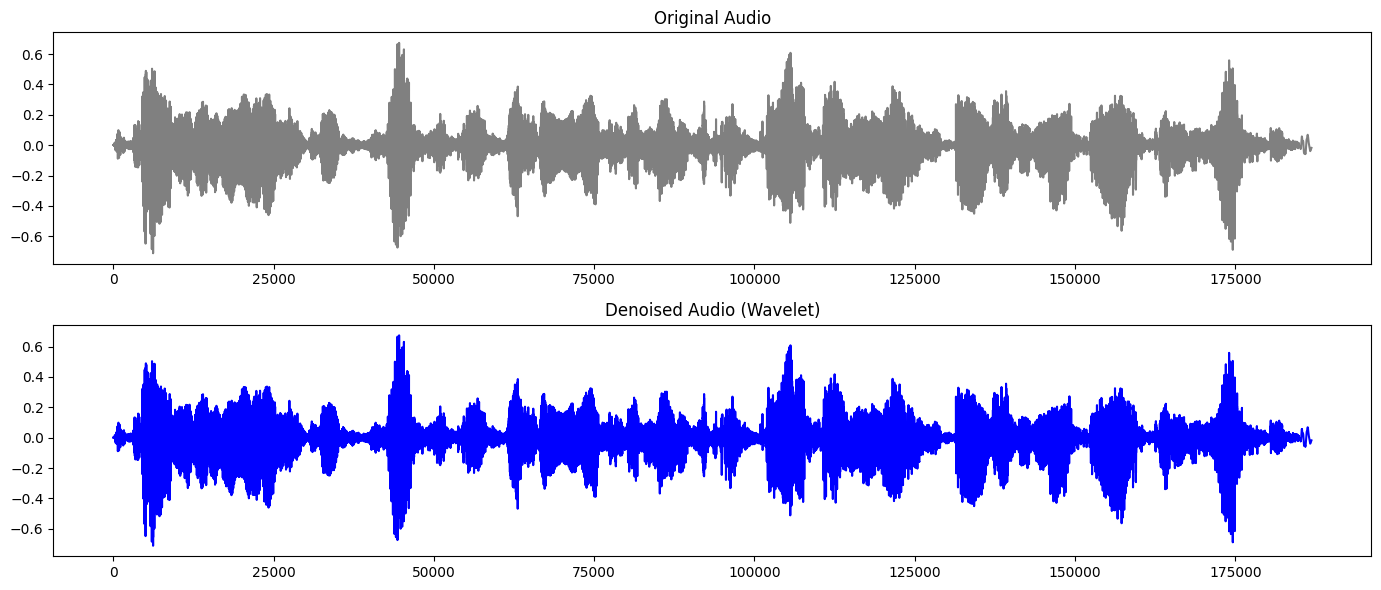

In [125]:
# denoising (step 2 preprocessing) --so far m4 bt3ml haga 

# Wavelet denoising function
def wavelet_denoise(signal, wavelet='db8', level=4, threshold_scale=0.04):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Estimate noise std dev
    threshold = threshold_scale * sigma

    denoised_coeffs = [
        pywt.threshold(c, threshold, mode='soft') if i > 0 else c
        for i, c in enumerate(coeffs)
    ]
    return pywt.waverec(denoised_coeffs, wavelet)

# testingg
speech_signal = apply_vad(audio, sr)
# Apply wavelet denoising
denoised_audio = wavelet_denoise(speech_signal)

# Make sure lengths match for plotting
min_len = min(len(speech_signal), len(denoised_audio))
speech_signal = speech_signal[:min_len]
denoised_audio = denoised_audio[:min_len]

# Plot before and after
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.title("Original Audio")
plt.plot(speech_signal, color='gray')
plt.subplot(2, 1, 2)
plt.title("Denoised Audio (Wavelet)")
plt.plot(denoised_audio, color='blue')
plt.tight_layout()
plt.show()

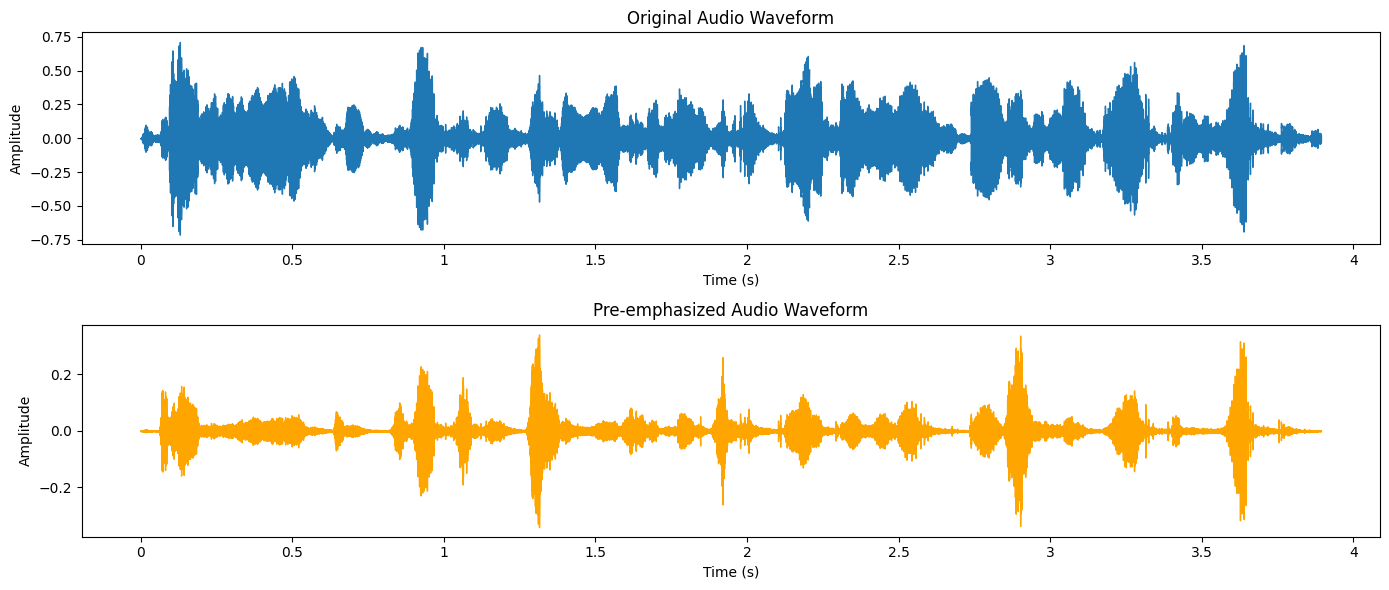

In [126]:
# Pre-emphasis (step 3 preprocessing) enhancing the SNR. less used in speech recognition processing. --n4elha?

def pre_emphasis(signal, coeff=0.97):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

# Apply pre-emphasis
y_preemphasized = pre_emphasis(denoised_audio, coeff=0.97)

# Plotting
plt.figure(figsize=(14, 6))

# Original waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(denoised_audio, sr=sr)
plt.title("Original Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Pre-emphasized waveform
plt.subplot(2, 1, 2)
librosa.display.waveshow(y_preemphasized, sr=sr, color='orange')
plt.title("Pre-emphasized Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [135]:
# Framing (step 4 preprocessing)

# Frame settings (25 ms frames, 10 ms hop)
frame_length = int(0.025 * sr)
hop_length = int(0.010 * sr)
def framing(denoised_audio, frame_length=frame_length, hop_length=hop_length):

    # Framing (2D array: shape = [frame_length, num_frames])
    return librosa.util.frame(denoised_audio, frame_length=frame_length, hop_length=hop_length)


In [128]:
# Apply Hamming window
def windowing(frames, frame_length):
    window = np.hamming(frame_length)
    windowed_frames = frames * window[:, np.newaxis]
    
    # plt.figure(figsize=(12, 4))

    # plt.subplot(1, 2, 1)
    # plt.plot(frames[:, 10], label="Original Frame")
    # plt.title("Original Frame")
    # plt.xlabel("Samples")
    # plt.ylabel("Amplitude")

    # plt.subplot(1, 2, 2)
    # plt.plot(windowed_frames[:, 10], label="Windowed Frame", color='orange')
    # plt.title("After Hamming Window")
    # plt.xlabel("Samples")

    # plt.tight_layout()
    # plt.show()
    return windowed_frames


In [129]:
# Normalization (step 6 preprocessing)

In [138]:
## combining preprocessing steps
def preprocess_audio(raw_audio, sr, frame_length=frame_length, hop_length=hop_length):

    # Step 1: VAD
    speech_signal = apply_vad(raw_audio, sr)

    if speech_signal is None or len(speech_signal) == 0:
        print("VAD removed all audio; skipping.")
        return None, None

    # Step 2: Denoising
    denoised_audio = wavelet_denoise(speech_signal)

    # Step 3: Pre-emphasis
    y_preemphasized = pre_emphasis(denoised_audio)
    if(len(denoised_audio) < frame_length):
        return None, None
    # Step 4: Framing
    frames = framing(denoised_audio, frame_length, hop_length)

    # Step 5: Windowing
    windowed_frames = windowing(frames, frame_length)

    # Step 6: Normalization (optional)
    normalized_frames = windowed_frames / np.max(np.abs(windowed_frames))

    return normalized_frames, windowed_frames

In [131]:
# STE - feature?

def short_time_energy_from_windowed(windowed_frames):
    energy = np.sum(windowed_frames ** 2, axis=0)
    return energy

def short_time_energy(y, sr, windowed_frames, hop_length):
    # STE calculation
    energy = short_time_energy_from_windowed(windowed_frames)

    # Time axis
    times = librosa.frames_to_time(range(len(energy)), sr=sr, hop_length=hop_length)

    return {
        'mean_energy': np.mean(energy),
        'std_energy': np.std(energy),
        'max_energy': np.max(energy),
        'min_energy': np.min(energy),
        'energy_variance': np.var(energy),
    }

# Plotting
# plt.figure(figsize=(10, 4))
# plt.plot(times, energy, label='Short-Time Energy')
# plt.xlabel('Time (s)')
# plt.ylabel('Energy')
# plt.title('Short-Time Energy (using windowed frames)')
# plt.grid()
# plt.tight_layout()
# plt.show()

In [132]:
# MFCC 13 coeff wel delta wel del2 brdo 
# ----- 1. MFCCs -----
def calculate_mfcc(denoised_audio, sr):
    mfcc = librosa.feature.mfcc(y=denoised_audio, sr=sr, n_mfcc=13)
    mfcc_means = np.mean(mfcc, axis=1)
    mfcc_stds = np.std(mfcc, axis=1)

    # ----- 2. Delta MFCCs -----
    delta_mfcc = librosa.feature.delta(mfcc)
    delta_means = np.mean(delta_mfcc, axis=1)
    delta_stds = np.std(delta_mfcc, axis=1)

    # ----- 3. Delta-Delta MFCCs -----
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    delta2_means = np.mean(delta2_mfcc, axis=1)
    delta2_stds = np.std(delta2_mfcc, axis=1)
    return {
        'mfcc_means': mfcc_means,
        'mfcc_stds': mfcc_stds,
        'delta_means': delta_means,
        'delta_stds': delta_stds,
        'delta2_means': delta2_means,
        'delta2_stds': delta2_stds
    }

# Print everything separately 
# print("MFCC Means:", mfcc_means)
# print("MFCC Stds:", mfcc_stds)

# print("Delta MFCC Means:", delta_means)
# print("Delta MFCC Stds:", delta_stds)

# print("Delta-Delta MFCC Means:", delta2_means)
# print("Delta-Delta MFCC Stds:", delta2_stds)

In [133]:

# Assume windowed_frames already exists from your framing+windowing step
def calculate_pitch_and_cepstrum(windowed_frames):
    mid_frame_idx = windowed_frames.shape[1] // 2
    windowed_frame = windowed_frames[:, mid_frame_idx]

    # FFT ‚Üí log magnitude spectrum
    spectrum = np.fft.fft(windowed_frame)
    log_magnitude = np.log(np.abs(spectrum) + 1e-10)

    # IFFT to get cepstrum
    cepstrum = np.fft.ifft(log_magnitude).real

    # Define pitch range (quefrency range)
    min_quefrency = int(sr / 400)  # ~400 Hz (high pitch)
    max_quefrency = int(sr / 60)   # ~60 Hz (low pitch)

    # Find the peak in that range
    pitch_quefrency = np.argmax(cepstrum[min_quefrency:max_quefrency]) + min_quefrency
    pitch_period = pitch_quefrency / sr
    pitch_frequency = 1.0 / pitch_period

    # Output pitch
    #print(f"Estimated Pitch: {pitch_frequency:.2f} Hz")
    return pitch_frequency, cepstrum, windowed_frame
# test
_,windowed_frames = preprocess_audio(denoised_audio, sr)
pitch_frequency, cepstrum, windowed_frame = calculate_pitch_and_cepstrum(windowed_frames)
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.title("Windowed Speech Frame")
plt.plot(windowed_frame)

plt.subplot(2, 1, 2)
plt.title("Cepstrum")
plt.plot(cepstrum)
# plt.axvline(pitch_quefrency, color='r', linestyle='--', label=f'Pitch ‚âà {pitch_frequency:.1f} Hz')
plt.legend()
plt.tight_layout()
plt.show()


186240
1200


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [ ]:
# kurt w skew (gpt)
def calculate_kurtosis_skewness(mfcc):
    kurt_val = kurtosis(mfcc[0])
    skew_val = skew(mfcc[0])
    return kurt_val, skew_val


In [ ]:

def compute_cpp_from_windowed(windowed_frames, sr):
    cpp_list = []

    for i in range(windowed_frames.shape[1]):
        frame = windowed_frames[:, i]  # one windowed frame

        spectrum = np.abs(fft(frame))**2
        log_spectrum = np.log(spectrum + 1e-10)
        cepstrum = np.real(ifft(log_spectrum))

        # Quefrency range for pitch (approx. 2 ms to 12.5 ms = 80 Hz to 500 Hz)
        quefrency_range = np.arange(int(sr / 500), int(sr / 80))
        peak_val = np.max(cepstrum[quefrency_range])
        peak_idx = np.argmax(cepstrum[quefrency_range]) + int(sr / 500)

        # Linear regression over the initial part of the cepstrum (trend)
        linear_range = cepstrum[:peak_idx]
        x = np.arange(len(linear_range))
        poly = np.polyfit(x, linear_range, 1)
        trend = np.polyval(poly, peak_idx)

        # CPP = peak - trend
        cpp = peak_val - trend
        cpp_list.append(cpp)

    return np.mean(cpp_list)

# Example usage
cpp_value = compute_cpp_from_windowed(windowed_frames, sr)
print("Estimated CPP:", cpp_value)


Estimated CPP: 0.09137984679483278


In [ ]:
# reading filtered data from csv file
import os
# Load your TSV
df = pd.read_csv("filtered_data_labeled.tsv", sep="\t")

# Set your audio directory
audio_dir = "F:/NN project/audio_batch_1"
available_files = set(os.listdir(audio_dir))

# Extract base filenames from 'path' column
df['filename'] = df['path'].apply(lambda x: os.path.basename(x))

# Filter rows to only those where the file exists
df = df[df['filename'].isin(available_files)]

# Rebuild full path now that we‚Äôve filtered
# Normalize full path to avoid mixed slashes
df['full_path'] = df['filename'].apply(lambda x: os.path.normpath(os.path.join(audio_dir, x)))

print(df['full_path'].head())

7     F:\NN project\audio_batch_1\common_voice_en_18...
18    F:\NN project\audio_batch_1\common_voice_en_19...
33    F:\NN project\audio_batch_1\common_voice_en_17...
60    F:\NN project\audio_batch_1\common_voice_en_17...
75    F:\NN project\audio_batch_1\common_voice_en_19...
Name: full_path, dtype: object


In [ ]:
def calculate_duration(y, sr):
    duration = len(y) / sr
    return duration

def calculate_wps(duration, row):
    # Count the number of words in the sentence
    word_count = len(row['sentence'].split())
    wps = word_count / duration
    return wps



In [ ]:
audio_path = df['full_path'].iloc[0]  # Example audio path
print(f"Processing audio file: {audio_path}")
y, sr = librosa.load(audio_path, sr=None)  # Load the audio file
duration = calculate_duration(y, sr)
wps = calculate_wps(duration, df.iloc[0])  # Calculate WPS for the first row
print(f"Duration: {duration:.2f} seconds")
print(f"Words per second: {wps:.2f}")

Processing audio file: F:\NN project\audio_batch_1\common_voice_en_18421093.mp3
Duration: 4.37 seconds
Words per second: 1.83


In [ ]:
# takes 20 seconds per sample !
def calculate_f0_features(y, sr):
    y_harmonic, _ = librosa.effects.hpss(y)
    # Estimate fundamental frequency (f0) using pyin
    f0, voiced_flag, _ = librosa.pyin(y_harmonic, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))

    # Handle NaNs by interpolating the missing values [3ashan el graph byebaa discontinuous]
    f0_interpolated = np.interp(np.arange(len(f0)), np.where(~np.isnan(f0))[0], f0[~np.isnan(f0)])

    # Compute features
    f0_mean = np.mean(f0_interpolated)
    f0_std = np.std(f0_interpolated)
    f0_5_percentile = np.percentile(f0_interpolated, 5)
    f0_95_percentile = np.percentile(f0_interpolated, 95)

    return {
        'mean': f0_mean,
        'std': f0_std,
        '5_percentile': f0_5_percentile,
        '95_percentile': f0_95_percentile
    }

f0_features = calculate_f0_features(y, sr)
print("F0 Features:")
print(f"Mean: {f0_features['mean']:.2f} Hz")
print(f"Standard Deviation: {f0_features['std']:.2f} Hz")
print(f"5th Percentile: {f0_features['5_percentile']:.2f} Hz")
print(f"95th Percentile: {f0_features['95_percentile']:.2f} Hz")

F0 Features:
Mean: 59.71 Hz
Standard Deviation: 11.89 Hz
5th Percentile: 36.29 Hz
95th Percentile: 80.69 Hz


In [ ]:
def calculate_tempo(y, sr, duration):
    # Compute the onset envelope
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)

    # Detect onsets (indicating the start of words or syllables)
    onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)

    speech_rate = len(onsets) / duration  # Onsets per second

    return speech_rate
tempo = calculate_tempo(y, sr, duration) # is it a good implementation? fe wahed tany lel songs bas dk which is better
# according to gpt : el far2 benha w ben words / sec en onsets aren't necessarily words 
        
print(f"Estimated Tempo: {tempo:.2f} BPM")

Estimated Tempo: 4.35 BPM


In [ ]:
import parselmouth
import numpy as np

def calculate_formants(y, sr):
    # Create a Parselmouth Sound object
    sound = parselmouth.Sound(y, sr)

    # Perform formant analysis (for the first 5 formants)
    formant = sound.to_formant_burg()
    
    # Get the formant frequencies at the mid-point of the signal
    time = len(y) / sr / 2  # Mid-point of the signal
    formant_freqs = [formant.get_value_at_time(i, time) for i in range(1, 4)]  # First 3 formants
    
    return formant_freqs


f1, f2, f3 = calculate_formants(y, sr) #f1 f2 f3
print(f1)
print(f2)
print(f3)


965.5765348716787
1840.8683552502537
2288.3826799234494


In [147]:
def extract_features_from_audio(y, sr):
    
    # Calculate duration
    duration = calculate_duration(y, sr)
    
    # Calculate WPS
    wps = calculate_wps(duration, df.iloc[0])  # Assuming df is already defined
    
    # Calculate f0 features
    f0_features = calculate_f0_features(y, sr)
    
    # Calculate tempo
    tempo = calculate_tempo(y, sr, duration)
    
    # Calculate formants
    f1, f2, f3 = calculate_formants(y, sr)

    # Calculate MFCC features
    
    
    return {
        'duration': duration,
        'wps': wps,
        'f0_mean': f0_features['mean'],
        'f0_std': f0_features['std'],
        'f0_5_percentile': f0_features['5_percentile'],
        'f0_95_percentile': f0_features['95_percentile'],
        'tempo': tempo,
        'formants': (f1, f2, f3)
    }

# Reading Data and Extracting features

In [ ]:
# reading data => keeping 1k males and 1k females with 0 downvotes and duration > ?
from tqdm import tqdm 
durations = []
# list to keep y,sr then append them to the df
y_list = []
sr_list = []
print("‚è±Ô∏è Calculating durations...")
for path in tqdm(df['full_path'], desc="Processing"):
    try:
        y, sr = librosa.load(path, sr=None)
        y_list.append(y)
        sr_list.append(sr)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
    except Exception as e:
        print(f"‚ö†Ô∏è Error with file {path}: {e}")
        y_list.append(None)
        sr_list.append(None)
        durations.append(None)

df['duration'] = durations
df['y'] = y_list
df['sr'] = sr_list

# Step 2: Filter by downvotes == 0 and duration > threshold (e.g. 1 second)
# duration insights
print("üìä Duration statistics:"
      f"\n{df['duration'].describe()}")





‚è±Ô∏è Calculating durations...


Processing:   0%|          | 19/10490 [00:00<00:56, 184.48it/s]C:\Users\MM\AppData\Local\Temp\ipykernel_15268\4052931135.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None)
C:\Users\MM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing:   1%|          | 62/10490 [00:00<00:51, 202.65it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_589236.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73377.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73383.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_614895.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_650493.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_687580.mp3: 


Processing:   1%|‚ñè         | 135/10490 [00:00<00:45, 228.72it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_573132.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_510009.mp3: 


Processing:   2%|‚ñè         | 204/10490 [00:00<00:46, 221.13it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_629830.mp3: 


Processing:   3%|‚ñé         | 298/10490 [00:01<00:45, 223.33it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_47417.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_585457.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_614635.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_498273.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_564718.mp3: 


Processing:   4%|‚ñé         | 389/10490 [00:01<00:46, 218.13it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_59730.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_529494.mp3: 


Processing:   4%|‚ñç         | 459/10490 [00:02<00:52, 191.54it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_554964.mp3: 


Processing:   5%|‚ñå         | 576/10490 [00:02<00:45, 217.28it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_485218.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_485225.mp3: 


Processing:   6%|‚ñå         | 603/10490 [00:02<00:42, 230.89it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_66560.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_66568.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_539028.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_539034.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_539036.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_680070.mp3: 


Processing:   7%|‚ñã         | 725/10490 [00:03<00:41, 235.86it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543588.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_66077.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_557125.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_557130.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_557140.mp3: 


Processing:   8%|‚ñä         | 822/10490 [00:03<00:42, 226.21it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_584852.mp3: 


Processing:   8%|‚ñä         | 868/10490 [00:03<00:43, 222.92it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_643102.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_482660.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_659687.mp3: 


Processing:   9%|‚ñâ         | 970/10490 [00:04<00:39, 243.56it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_57283.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_57284.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_57285.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_630334.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_573475.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_39050.mp3: 


Processing:  10%|‚ñà         | 1076/10490 [00:04<00:38, 243.28it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_664187.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_664189.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_664207.mp3: 


Processing:  11%|‚ñà         | 1177/10490 [00:05<00:38, 243.20it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_571245.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_558024.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_43450.mp3: 


Processing:  12%|‚ñà‚ñè        | 1300/10490 [00:05<00:41, 223.83it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_691859.mp3: 


Processing:  13%|‚ñà‚ñé        | 1372/10490 [00:06<00:40, 226.53it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_662892.mp3: 


Processing:  14%|‚ñà‚ñç        | 1520/10490 [00:06<00:35, 250.77it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_611994.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_612030.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_533672.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_533704.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_533719.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_566296.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_566304.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_566312.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_566321.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_566345.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_566350.mp3: 


Processing:  15%|‚ñà‚ñå        | 1619/10490 [00:07<00:39, 224.63it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_615348.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_79539.mp3: 


Processing:  17%|‚ñà‚ñã        | 1735/10490 [00:07<00:41, 212.65it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_598084.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_598147.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_670367.mp3: 


Processing:  17%|‚ñà‚ñã        | 1799/10490 [00:08<00:42, 202.40it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_609410.mp3: 


Processing:  18%|‚ñà‚ñä        | 1873/10490 [00:08<00:37, 227.35it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_493425.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_493427.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_493466.mp3: 


Processing:  21%|‚ñà‚ñà        | 2152/10490 [00:09<00:38, 215.05it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_616014.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_616036.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_616043.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_616054.mp3: 


Processing:  21%|‚ñà‚ñà        | 2219/10490 [00:10<00:38, 213.35it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_612238.mp3: 


Processing:  24%|‚ñà‚ñà‚ñé       | 2469/10490 [00:11<00:35, 225.03it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499690.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499711.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499724.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499728.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499770.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499790.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499851.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499854.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499876.mp3: 


Processing:  27%|‚ñà‚ñà‚ñã       | 2855/10490 [00:13<00:38, 198.29it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_573908.mp3: 


Processing:  30%|‚ñà‚ñà‚ñâ       | 3107/10490 [00:14<00:33, 217.52it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84196.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84229.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84284.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84289.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84292.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84309.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84358.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84594.mp3: 


Processing:  30%|‚ñà‚ñà‚ñà       | 3164/10490 [00:14<00:31, 232.52it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_671757.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_671780.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_671794.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_671914.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_672014.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_672058.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_672093.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_672134.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_672160.mp3: 


Processing:  35%|‚ñà‚ñà‚ñà‚ñç      | 3646/10490 [00:16<00:31, 219.72it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_546836.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547107.mp3: 


Processing:  38%|‚ñà‚ñà‚ñà‚ñä      | 3943/10490 [00:18<00:29, 223.80it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_629809.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_413119.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_502622.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_591530.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_481983.mp3: 


Processing:  38%|‚ñà‚ñà‚ñà‚ñä      | 4003/10490 [00:18<00:24, 259.80it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_429559.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_698682.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607196.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_393686.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_577490.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_522980.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_550684.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_648427.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_410692.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_9920835.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_625563.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_652583.mp3: 
‚ö†Ô∏è Error with file F:\NN project\au

Processing:  39%|‚ñà‚ñà‚ñà‚ñä      | 4054/10490 [00:18<00:27, 237.41it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_554723.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_560429.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_544341.mp3: 


Processing:  39%|‚ñà‚ñà‚ñà‚ñâ      | 4105/10490 [00:18<00:26, 240.17it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_89829.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_483289.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621639.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_557460.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_640422.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_372740.mp3: 


Processing:  40%|‚ñà‚ñà‚ñà‚ñâ      | 4173/10490 [00:18<00:21, 290.47it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_541570.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_564499.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_655602.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_602396.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_449811.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_8808.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_573303.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608682.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_405540.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_6747372.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_613991.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_437656.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audi

Processing:  41%|‚ñà‚ñà‚ñà‚ñà      | 4251/10490 [00:19<00:18, 332.23it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_662410.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_507894.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_598821.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_571998.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_653893.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_534207.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_534214.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_45163.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_90909.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_507396.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_659580.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_66043.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_

Processing:  41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 4340/10490 [00:19<00:16, 380.97it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42590.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42599.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42603.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_504174.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_504181.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_479497.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_485187.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_485195.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_408705.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_577458.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_569462.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_667631.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_

Processing:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 4455/10490 [00:19<00:16, 363.65it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_37845.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_444283.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_444293.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_533417.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642823.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_691085.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_71926.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_4445147.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_4445153.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_71622.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_693388.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_693397.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audi

Processing:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 4530/10490 [00:19<00:16, 364.19it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_63877.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_556747.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_507913.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_429266.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_429268.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_592434.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_63619.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_554838.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_548762.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_514781.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_698562.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_45180.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_

Processing:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 4608/10490 [00:20<00:15, 374.09it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_658970.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_79252.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_521532.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_533579.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_596203.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_555228.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_555233.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41185.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_437335.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_529678.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_529685.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_529687.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio

Processing:  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 4698/10490 [00:20<00:16, 343.82it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_563050.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_574175.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_574178.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_417114.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_417115.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_577114.mp3: 


Processing:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 4776/10490 [00:20<00:15, 361.83it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_700703.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_519194.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_551524.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_390671.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_390677.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608880.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_373485.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_373492.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_682541.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_553666.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_553670.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_664696.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 4866/10490 [00:20<00:14, 401.62it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_595282.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_557369.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_557375.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_83435.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608064.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_75330.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73245.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_623725.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_552087.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_62356.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_619998.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_610625.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_b

Processing:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 4907/10490 [00:20<00:14, 393.85it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486198.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_492462.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_492468.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_546529.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_546538.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_657885.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_532632.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_43108.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_637178.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_637189.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_5723064.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_575510.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 4985/10490 [00:21<00:15, 365.36it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608373.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_66271.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_45185.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_588631.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_532738.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_586152.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_586166.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_586168.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_60067.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_60076.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_633677.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_586739.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_b

Processing:  49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 5098/10490 [00:21<00:15, 356.98it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_641899.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_591813.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_591828.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_678208.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_678220.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_678229.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_37811.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_37817.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_37818.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_37822.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_454825.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_69129.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_ba

Processing:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 5168/10490 [00:21<00:15, 334.33it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_71555.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_485653.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_485658.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53214.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53215.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_498106.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_556962.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_561748.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_662961.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_662993.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_632252.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_630710.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_

Processing:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 5235/10490 [00:21<00:16, 316.51it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_490826.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_490830.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_489082.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_489091.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_489108.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_6635553.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_640805.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_532909.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_614238.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_614250.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_482667.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_533395.mp3: 
‚ö†Ô∏è Error with file F:\NN project\au

Processing:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 5320/10490 [00:22<00:14, 369.10it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_648192.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_648202.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_648217.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_545857.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_673412.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_673424.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_673429.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_89560.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_555762.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_555763.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_555774.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_63769.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio

Processing:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 5394/10490 [00:22<00:14, 349.91it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_489036.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_537421.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_537441.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_537445.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642778.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642787.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642798.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642807.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_532991.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_532995.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_533000.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_533006.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 5474/10490 [00:22<00:13, 358.48it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_560993.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_575098.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_496890.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_655885.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_571041.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_571042.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_571051.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_571071.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_487483.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_571862.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_79205.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_507408.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audi

Processing:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 5558/10490 [00:22<00:13, 364.09it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_580553.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_598618.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_612049.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_612063.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_612078.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_612080.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_517139.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_55879.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_55883.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_55902.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_55904.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_664166.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_b

Processing:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 5634/10490 [00:23<00:13, 365.64it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_660631.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41638.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41654.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41660.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_700690.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_9122392.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_643649.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_497359.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_497391.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_37051.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_37058.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_603889.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_b

Processing:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 5714/10490 [00:23<00:12, 377.48it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_626175.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_626179.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_626209.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_488819.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_488833.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_488834.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_563817.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_563843.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_559958.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_559980.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_559988.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_571253.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 5819/10490 [00:23<00:11, 408.32it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_522885.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_522893.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_522894.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_522902.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_8237488.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_592164.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_54411.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_54415.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_54429.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_373915.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_612343.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_62486.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_

Processing:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 5900/10490 [00:23<00:12, 375.43it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_566124.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_566126.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_483876.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_483882.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_483916.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_600034.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_600055.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_654716.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_570636.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_570666.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_570684.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_5170505.mp3: 
‚ö†Ô∏è Error with file F:\NN project\au

Processing:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 5981/10490 [00:23<00:12, 368.08it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_477797.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_477840.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_658405.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_658407.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_658423.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_520241.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_520282.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_576189.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_576210.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_516553.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_516559.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_516590.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 6134/10490 [00:24<00:09, 448.37it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_615164.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_615165.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_615176.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_615219.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_568894.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_568906.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_568923.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_568934.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_614022.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_614029.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_614054.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_614062.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 6237/10490 [00:24<00:09, 428.42it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_559797.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_559827.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_559850.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42032.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42051.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42067.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42071.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42075.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42078.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_42093.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499994.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499999.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batc

Processing:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 6281/10490 [00:24<00:10, 407.32it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_48542.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_667304.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_667309.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_667323.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_657512.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_657521.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_657531.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_657555.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_657556.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_657582.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_700106.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_700108.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audi

Processing:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 6404/10490 [00:24<00:10, 381.55it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_666565.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_666581.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_666587.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_666599.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_620798.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_620806.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_620813.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_620851.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_637422.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_637436.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_637468.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_711605.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 6447/10490 [00:25<00:10, 394.79it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_478601.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_478602.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_478609.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_478652.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_83794.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_83820.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_498594.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_498609.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_498626.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_498643.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_4237215.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_4237238.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 6566/10490 [00:25<00:10, 364.39it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_615358.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_9110.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_9112.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_9139.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_49670.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_49727.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_49737.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_82357.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_82372.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_82374.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_82415.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_82451.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\com

Processing:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 6672/10490 [00:25<00:08, 443.73it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_587169.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_587194.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_79602.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_685478.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_685526.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608522.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608531.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608548.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608583.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_608584.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_523109.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_523128.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audi

Processing:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 6734/10490 [00:25<00:07, 491.21it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_52759.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_52819.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_52842.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_598087.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_598106.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_521315.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_521346.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_521352.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_521358.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_521377.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_521381.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_521386.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_

Processing:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 6831/10490 [00:25<00:08, 438.58it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_602934.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_602976.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_602993.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_603010.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_603016.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_603025.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_670533.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_670536.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_695046.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_695054.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_695056.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_695106.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 6926/10490 [00:26<00:08, 416.88it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_595371.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_595453.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_595457.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_595468.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_595476.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_493464.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_684130.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_523280.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_523304.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_523356.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_523366.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_539098.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 7004/10490 [00:26<00:15, 218.46it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_97643.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_97669.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_97712.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_97717.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_65257.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_79425.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_79438.mp3: 


Processing:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 7082/10490 [00:26<00:12, 275.34it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_518316.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_518350.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_518402.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_508802.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_508838.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_508840.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_508878.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_508889.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_508914.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_553413.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_553424.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_553453.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 7115/10490 [00:27<00:13, 256.32it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_478689.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_478714.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_478755.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_478797.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_450668.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_450695.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_450733.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_450787.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_78683.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_78735.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_78753.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_78755.mp3: 


Processing:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 7185/10490 [00:27<00:14, 223.72it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540130.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540144.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540168.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540190.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540195.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540216.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540218.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540249.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_540251.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515709.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515713.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515730.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 7237/10490 [00:27<00:16, 192.87it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38819.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38858.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38899.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38924.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38934.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_98875.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_98909.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_98934.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_98935.mp3: 


Processing:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 7299/10490 [00:28<00:19, 161.36it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515405.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515440.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515442.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515458.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515459.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515479.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515537.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_515555.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_696497.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_696541.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_696551.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_696554.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 7377/10490 [00:28<00:14, 221.88it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642401.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642430.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642481.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642501.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642520.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642528.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_642529.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543405.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543444.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543463.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543473.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543474.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 7501/10490 [00:29<00:10, 289.06it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_99432.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_99437.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_99465.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_99483.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_99503.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_99509.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_99566.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_99574.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_624301.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_624325.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_624347.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_624352.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch

Processing:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 7601/10490 [00:29<00:09, 301.17it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_628386.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_628394.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_628399.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_628435.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_628445.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_628487.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_47434.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_47435.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_47442.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_47468.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_47474.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_47483.mp3: 


Processing:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 7632/10490 [00:29<00:10, 259.94it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_512491.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_512499.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_512511.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_512529.mp3: 


Processing:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 7700/10490 [00:30<00:21, 130.17it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_61707.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_61709.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_61717.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_61718.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_61757.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_61842.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_567441.mp3: 


Processing:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 7741/10490 [00:30<00:15, 178.66it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_567514.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_567520.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_567526.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_567532.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_567553.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_567562.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41446.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41447.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41558.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41571.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_41575.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_497689.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_ba

Processing:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 7859/10490 [00:30<00:11, 228.05it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_72603.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_72610.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_72613.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_72638.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_72713.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_72741.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499809.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499857.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74483.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74485.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74495.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74511.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1

Processing:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 7933/10490 [00:31<00:08, 288.83it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74806.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74836.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74885.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74907.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74954.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_74970.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_484419.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_484473.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_484477.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_484479.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_484498.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_484557.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_bat

Processing:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 8080/10490 [00:31<00:13, 185.16it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_613164.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_613180.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_613200.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_613248.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_613252.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_613394.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_613396.mp3: 


Processing:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 8166/10490 [00:32<00:10, 228.71it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_81584.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_81615.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_81627.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_81659.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_81753.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_511532.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_511546.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_511550.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_511551.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_511552.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_511583.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_511585.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_ba

Processing:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 8263/10490 [00:32<00:08, 258.09it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486777.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486788.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486789.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486801.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486832.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486871.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486875.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486936.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486952.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_486962.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_487029.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_604947.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 8368/10490 [00:33<00:17, 119.29it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528306.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528327.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528388.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528399.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528510.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528519.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528531.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528538.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528546.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528550.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528585.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_528598.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 8468/10490 [00:34<00:09, 220.93it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_37990.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38083.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38107.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38125.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38169.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38174.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38184.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38198.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38214.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38220.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38223.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_38254.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\c

Processing:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 8544/10490 [00:34<00:06, 281.95it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543824.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543831.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543833.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543848.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543877.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_543907.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_544000.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_544009.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_544013.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_544020.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_544059.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_544071.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 8662/10490 [00:34<00:05, 345.83it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53527.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53571.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53611.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53616.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53677.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53689.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53701.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53707.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_53750.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_678352.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_678380.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_678449.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_

Processing:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 8824/10490 [00:35<00:04, 378.08it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621152.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621153.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621164.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621166.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621302.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621315.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621335.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621381.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621412.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621420.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621429.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621442.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 8945/10490 [00:35<00:04, 336.27it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647724.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647743.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647763.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647820.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647825.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647836.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647895.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647910.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647952.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647955.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_647981.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_648008.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 9183/10490 [00:36<00:03, 339.28it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_596972.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597021.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597022.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597028.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597057.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597078.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597079.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597083.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597095.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597110.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597121.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_597145.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 9253/10490 [00:36<00:04, 304.65it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84205.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84296.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_84377.mp3: 


Processing:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 9360/10490 [00:36<00:02, 406.29it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499012.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499056.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499092.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499122.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499123.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499246.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499282.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499288.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499301.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499374.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499397.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_499399.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 9448/10490 [00:36<00:02, 413.56it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_91904.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_91966.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92006.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92037.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92049.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92085.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92137.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92143.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92280.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92301.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_92321.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_530784.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\

Processing:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 9577/10490 [00:37<00:02, 370.62it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607208.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607235.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607247.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607259.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607268.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607320.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607325.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607366.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607380.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607387.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607388.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_607464.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 9663/10490 [00:37<00:02, 379.41it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_667997.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668016.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668044.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668119.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668142.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668161.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668171.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668227.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668230.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668249.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668281.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_668299.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 9796/10490 [00:37<00:01, 394.38it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494628.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494629.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494659.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494666.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494689.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494721.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494735.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494795.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494852.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494900.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494902.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_494912.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 9898/10490 [00:38<00:01, 427.59it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_546859.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_546918.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_546921.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_546948.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547014.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547036.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547133.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547141.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547202.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547234.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547262.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_547264.mp3: 
‚ö†Ô∏è Error with file F:\NN project\aud

Processing:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 9983/10490 [00:38<00:01, 362.60it/s]

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621764.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621778.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621797.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621812.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621838.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621839.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621881.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621891.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621908.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621935.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_621936.mp3: 


Processing:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 10262/10490 [00:44<00:02, 82.30it/s] 

‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73559.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73674.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73676.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73695.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73800.mp3: 
‚ö†Ô∏è Error with file F:\NN project\audio_batch_1\common_voice_en_73837.mp3: 


Processing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10490/10490 [00:47<00:00, 223.10it/s]


üìä Duration statistics:
count    8612.000000
mean        4.713205
std         1.816155
min         0.984000
25%         3.378000
50%         4.488000
75%         5.862000
max        56.184000
Name: duration, dtype: float64


In [ ]:
duration_threshold = 2.0  
df_filtered = df[(df['down_votes'] == 0) & (df['duration'] > duration_threshold)]

# Step 3: Sample 1000 males and 1000 females
df_male = df_filtered[df_filtered['gender'] == 'male'].sample(n=1000, random_state=42)
df_female = df_filtered[df_filtered['gender'] == 'female'].sample(n=1000, random_state=42)

# Combine the two
df_final = pd.concat([df_male, df_female]).reset_index(drop=True)

# Confirm
print(f"‚úÖ Final dataset has {len(df_final)} rows (1000 male, 1000 female).")
print(df_final[['gender', 'down_votes', 'duration']].describe())


‚úÖ Final dataset has 2000 rows (1000 male, 1000 female).
       down_votes     duration
count      2000.0  2000.000000
mean          0.0     4.798332
std           0.0     2.012390
min           0.0     2.016000
25%           0.0     3.456000
50%           0.0     4.584000
75%           0.0     5.904000
max           0.0    56.184000


üìä Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   2000 non-null   object 
 1   path        2000 non-null   object 
 2   sentence    2000 non-null   object 
 3   up_votes    2000 non-null   int64  
 4   down_votes  2000 non-null   int64  
 5   age         2000 non-null   object 
 6   gender      2000 non-null   object 
 7   accent      1507 non-null   object 
 8   label       2000 non-null   int64  
 9   filename    2000 non-null   object 
 10  full_path   2000 non-null   object 
 11  duration    2000 non-null   float64
 12  y           2000 non-null   object 
 13  sr          2000 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 218.9+ KB
None

üîç Sample Rows:
                                           client_id  \
0  a766b9ec3220fe0f327736a0d09a071e3cdc5eb710dee4...   
1  cbeae2c03dab046

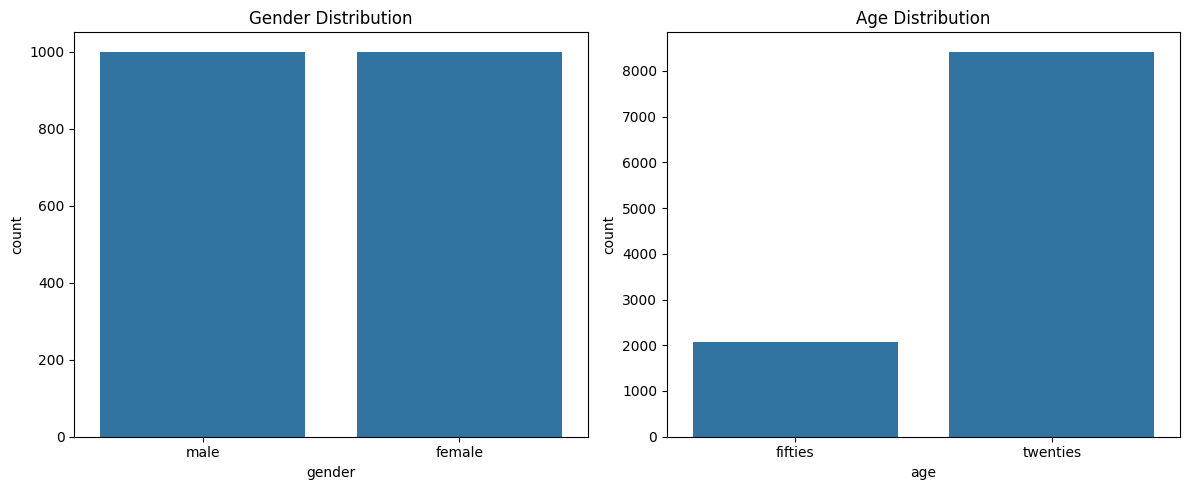

In [ ]:
import seaborn as sns
print("üìä Dataset Info:")
print(df_final.info())
print("\nüîç Sample Rows:")
print(df_final.head())

# Check class balance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x="gender", data=df_final)
plt.title("Gender Distribution")

plt.subplot(1, 2, 2)
sns.countplot(x="age", data=df, order=sorted(df_final['age'].dropna().unique()))
plt.title("Age Distribution")

plt.tight_layout()
plt.show()


In [139]:
# preprocess and extract features for the final dataset
# loop on data fram [y] and [sr] columns and apply the function on them if not none
normalized_frames = []
windowed_frames = []

for i in tqdm(range(len(df_final)), desc="Processing"):
    y = df_final['y'].iloc[i]
    sr = df_final['sr'].iloc[i]
    frame_length = int(0.025 * sr)  # 25 ms frames
    hop_length = int(0.010 * sr)  # 10 ms hop length
    if y is not None and sr is not None and len(y) >= frame_length:
        norm_frames, win_frames = preprocess_audio(y, sr, frame_length, hop_length)
        normalized_frames.append(norm_frames)
        windowed_frames.append(win_frames)
    else:
        normalized_frames.append(None)
        windowed_frames.append(None)





Processing:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 1818/2000 [00:59<00:07, 25.49it/s]

VAD removed all audio; skipping.


Processing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2000/2000 [01:06<00:00, 30.18it/s]


In [145]:
# filter out None values
valid_indices = [i for i, (nf, wf) in enumerate(zip(normalized_frames, windowed_frames))
                 if nf is not None and wf is not None]

# Filter everything
df_filtered = df_final.iloc[valid_indices].reset_index(drop=True)
normalized_frames = [normalized_frames[i] for i in valid_indices]
windowed_frames = [windowed_frames[i] for i in valid_indices]
print("normalized_frames",normalized_frames[:5])
print("windowed_frames",windowed_frames[:5])

print(f"Filtered dataset size: {len(df_filtered)}")
print(df_filtered.head())

normalized_frames [array([[ 1.27362737e-03,  3.25641216e-03,  3.55014061e-03, ...,
         2.64996570e-03,  5.66654482e-03, -4.62172811e-04],
       [-1.58151771e-04,  3.81995763e-03,  3.43577322e-03, ...,
         2.46373588e-03,  4.88138111e-03,  3.43695481e-04],
       [-1.35960049e-03,  4.67295539e-03,  2.44511892e-03, ...,
         2.43545741e-03,  4.31017709e-03, -1.07626622e-05],
       ...,
       [ 1.17146507e-03, -5.85672742e-03, -2.96010091e-04, ...,
         1.28224337e-04, -2.12863993e-03,  4.30978519e-03],
       [ 1.67266495e-03, -5.78804435e-03, -9.35401461e-04, ...,
        -6.17418399e-05, -2.10251646e-03,  3.58248186e-03],
       [ 1.96501838e-03, -6.04779490e-03, -5.13531491e-04, ...,
        -2.81387696e-04, -1.57233730e-03,  3.02150393e-03]]), array([[ 7.80552042e-04,  4.72437616e-04, -3.23310373e-05, ...,
         5.73930816e-03,  8.25548914e-03,  2.76447125e-03],
       [ 2.06470627e-03,  1.53883194e-03, -2.00738782e-04, ...,
         5.61876340e-03,  4.3327572

In [148]:
# extract features from the filtered dataset
features_list = []
for i in tqdm(range(len(df_filtered)), desc="Extracting features"):
    y = df_filtered['y'].iloc[i]
    sr = df_filtered['sr'].iloc[i]

    if y is not None and sr is not None:
        features = extract_features_from_audio(y, sr)
        features_list.append(features)
    else:
        features_list.append(None)

Extracting features:   1%|          | 16/1998 [04:28<9:13:42, 16.76s/it] 


KeyboardInterrupt: 

In [150]:
# print feature list each on a line
for features in features_list:
    if features is not None:
        print(features)
    else:
        print("No features extracted for this sample.")

{'duration': 3.624, 'wps': 2.2075055187637966, 'f0_mean': 44.27823201474654, 'f0_std': 6.70497536055146, 'f0_5_percentile': 33.80112002783417, 'f0_95_percentile': 56.93957081127576, 'tempo': 4.966887417218543, 'formants': (684.2766134506771, 2144.732065909452, 3551.312656114038)}
{'duration': 8.28, 'wps': 0.9661835748792271, 'f0_mean': 52.74742481992249, 'f0_std': 8.610053945812341, 'f0_5_percentile': 39.342763141969606, 'f0_95_percentile': 66.43972743779952, 'tempo': 5.676328502415459, 'formants': (528.7193019012223, 1327.5116012478884, 2695.891256759568)}
{'duration': 3.36, 'wps': 2.380952380952381, 'f0_mean': 41.4172806031692, 'f0_std': 4.064058099988801, 'f0_5_percentile': 33.86405278847176, 'f0_95_percentile': 47.604510855337864, 'tempo': 3.5714285714285716, 'formants': (629.2611156890191, 1991.7301440762662, 3142.621149209976)}
{'duration': 5.472, 'wps': 1.461988304093567, 'f0_mean': 52.16168887666411, 'f0_std': 12.66374668020815, 'f0_5_percentile': 33.84774270944974, 'f0_95_perc